## Data Import from Website

The required packages are
- Obspy: for working with earthquake seimsic data
- Basemap or Cartopy: for plotting maps

In [65]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import date2num

from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees

from sklearn.decomposition import PCA
from matplotlib import mlab

49 Event(s) in Catalog:
2016-10-02T22:37:15.940000Z | +35.904, -120.451 | 3.02 Ml | manual
2016-05-17T22:58:06.000000Z | +35.969, -120.526 | 3.5 Mw | manual
...
2002-08-18T08:09:53.990000Z | +35.939, -120.486 | 3.12 Md | manual
2001-04-13T02:48:42.890000Z | +35.955, -120.503 | 3.4 Ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


C:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


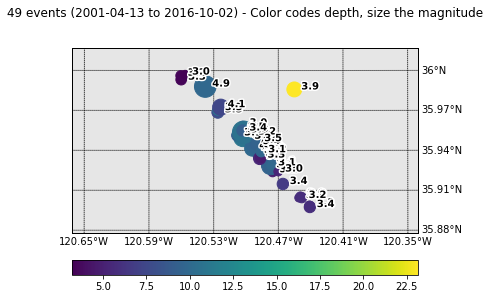

In [62]:
# define station and other parameters
networkName      = "BK"
stationName      = "PKD"
clientName       = "NCEDC"
starttime        = UTCDateTime("2000-01-01")
endtime          = UTCDateTime("2018-04-06")
maxRadius        = .1
minMagnitude     = 3
channelName      = "LHZ"

client = Client(clientName)
inventory = client.get_stations(network=networkName, station=stationName)
station = inventory[0][0]
cat = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=minMagnitude, latitude=station.latitude, longitude=station.longitude, maxradius=maxRadius)

print(cat)  
cat.plot(projection="local");

## Save Data to CSV
We will store the data in a list

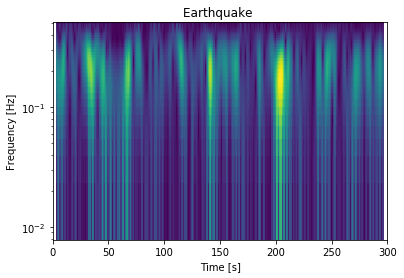

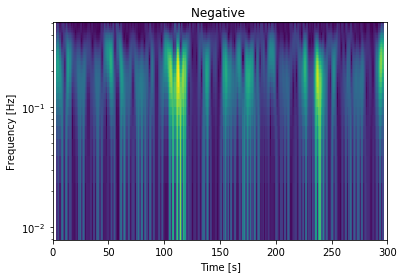

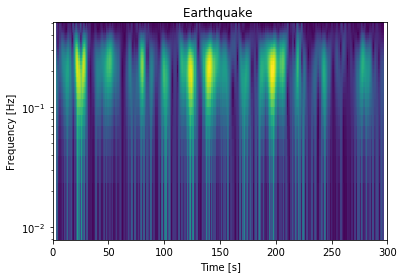

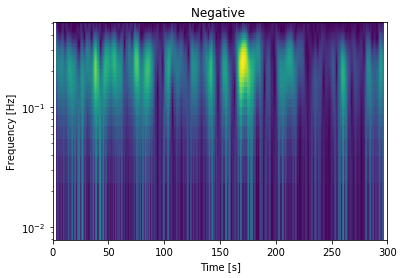

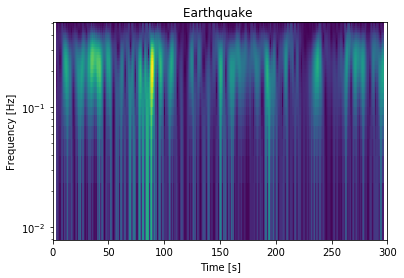

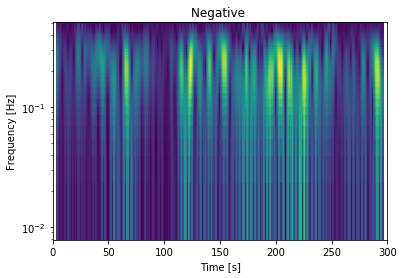

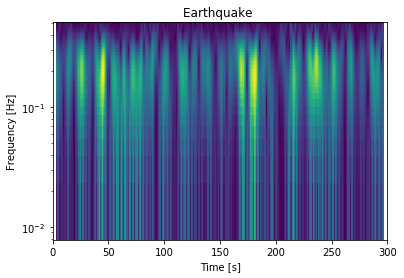

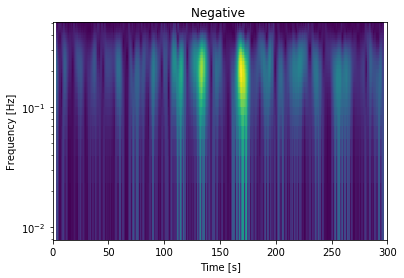

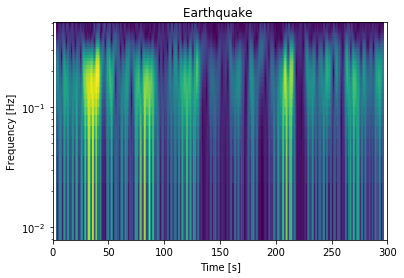

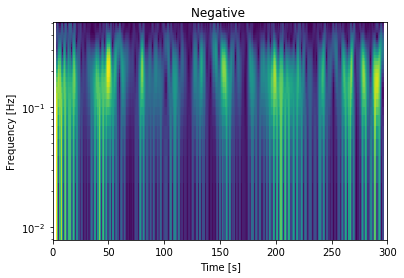

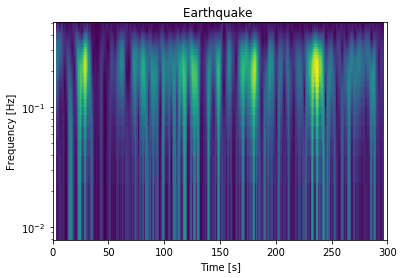

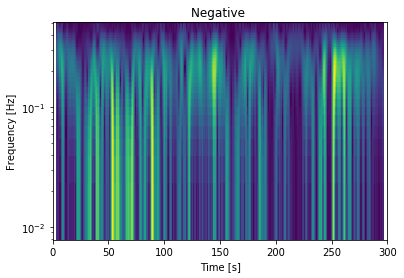

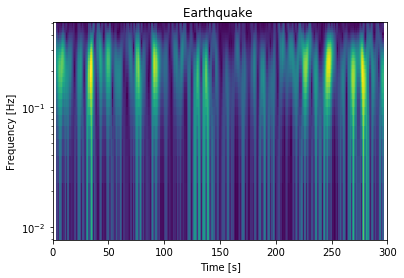

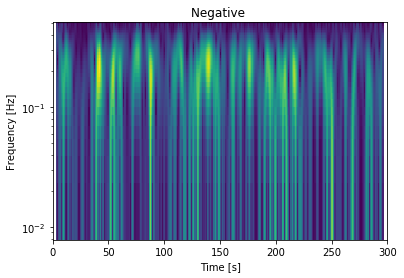

In [63]:
model = TauPyModel(model="iasp91")
nEvents = len(cat)
dataList  = []
labelList = []
timeList = []
streamList  =[]

for i in range(0, nEvents):
    try:
        event = cat[i]
        origin = event.origins[0]
        distance, _, _ = gps2dist_azimuth(origin.latitude, origin.longitude, station.latitude, station.longitude)
        distance = kilometer2degrees(distance / 1e3)
        arrivals = model.get_travel_times(origin.depth / 1e3, distance)
        #print(arrivals)
        traveltime = arrivals[0].time
        arrival_time = origin.time + traveltime
                
        # Get the earthquake signal and store its needed information
        st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-400, endtime=arrival_time-100)
        streamList.append(st)
        st.spectrogram(log=True, wlen=10, title='Earthquake ' )
        # st.plot()
        trace = st.pop()
        dataList.append(trace.data)
        timeList.append(trace.times('matplotlib'))
        labelList.append(1)
        
        # Get a non earthquake signal and store its needed information
        st = client.get_waveforms(network=networkName, station=stationName, location="00", channel=channelName, starttime=arrival_time-8700, endtime=arrival_time-8400)
        streamList.append(st)
        st.spectrogram(log=True, wlen=10, title='Negative ' )
        # st.plot()
        trace = st.pop()
        dataList.append(trace.data)
        timeList.append(trace.times('matplotlib'))
        labelList.append(0)
        
    except:
        pass

Now let's save the data in CSV file for later analysis

In [23]:
data = np.asarray(dataList).T;
np.save("Data.npy", data)

label = np.asarray(labelList).T;
label = np.expand_dims(label, axis=1)
np.save("Label.npy", label)

time = np.asarray(timeList).T;
np.save("Time.npy", time)

np.save("Stream.npy", streamList)

Now let us load the data and apply PCA to check on things

In [19]:
data = np.load("Data.npy")
label = np.load("Label.npy")
time = np.load("Time.npy")
stream = np.load("stream.npy")

In [20]:
nComponents = 5
allVar = np.zeros([nComponents, data.shape[1]])

for eventNumber in range(0, data.shape[1]):
    event = data[0:400,eventNumber]

    X = []
    window_size = 50
    for i in range(len(event) - window_size):
        x = []
        for j in range(window_size):
            x.append(event[i + j])
        X.append(x)
    X = np.asarray(X)


    pca = PCA(n_components = nComponents)
    scores = pca.fit_transform(X)
    variance = pca.explained_variance_ratio_

    allVar[:,eventNumber] = variance

plt.plot(allVar[0,:])
print(np.mean(allVar[0, 0:20:2]))
print(np.mean(allVar[0, 1:20:2]))
print(allVar[1, 0:20:2] - allVar[1, 1:20:2])

IndexError: tuple index out of range

In [69]:
def getSpectogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, zorder=None, title=None,
                show=True):
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)
    
    return specgram, freq, time

In [24]:
data.shape

(0,)

### Extracting raw data from previous trace

In [ ]:
st = st.pop()
x = st.times('matplotlib')
y = st.data
fig = plt.figure(figsize=(12, 4))
plt.plot(x, y, '-')